In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import shap


In het artikel geven ze aan dat ze met de red wine gewerkt hebben: "we
have chosen redwine data for our study because of its popularity over the
white wine."

In [52]:

# Define the relative path to the CSV file
relative_path = 'wine+quality/winequality-red.csv'

# Read the CSV file using pandas
red_wine_df = pd.read_csv(relative_path, delimiter=';')

In [53]:

# Define the relative path to the CSV file
relative_path = 'wine+quality/winequality-white.csv'

# Read the CSV file using pandas
white_wine_df = pd.read_csv(relative_path, delimiter=';')




In [54]:
# Display the first few rows of the data
print(red_wine_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [55]:
len(red_wine_df)

1599

In het artikel geven ze aan dat de dataset 4898 samples bevat: "The dataset contains the records of 4898 random samples of wine manufactured."
Dit komt niet overeen met het aantal samples in de redwine dataset. Dit komt overeen met het aantal samples in de whitewine dataset.

In [56]:
len(white_wine_df)

4898

In [57]:
# Calculate the required statistics
statistics = red_wine_df.describe().T[['mean', 'std', 'min', 'max']]
statistics['median'] = red_wine_df.median()

# Display the statistics
print(statistics)


                           mean        std      min        max    median
fixed acidity          8.319637   1.741096  4.60000   15.90000   7.90000
volatile acidity       0.527821   0.179060  0.12000    1.58000   0.52000
citric acid            0.270976   0.194801  0.00000    1.00000   0.26000
residual sugar         2.538806   1.409928  0.90000   15.50000   2.20000
chlorides              0.087467   0.047065  0.01200    0.61100   0.07900
free sulfur dioxide   15.874922  10.460157  1.00000   72.00000  14.00000
total sulfur dioxide  46.467792  32.895324  6.00000  289.00000  38.00000
density                0.996747   0.001887  0.99007    1.00369   0.99675
pH                     3.311113   0.154386  2.74000    4.01000   3.31000
sulphates              0.658149   0.169507  0.33000    2.00000   0.62000
alcohol               10.422983   1.065668  8.40000   14.90000  10.20000
quality                5.636023   0.807569  3.00000    8.00000   6.00000


In [58]:
# Calculate the required statistics
statistics = white_wine_df.describe().T[['mean', 'std', 'min', 'max']]
statistics['median'] = white_wine_df.median()

# Display the statistics
print(statistics)


                            mean        std      min        max     median
fixed acidity           6.854788   0.843868  3.80000   14.20000    6.80000
volatile acidity        0.278241   0.100795  0.08000    1.10000    0.26000
citric acid             0.334192   0.121020  0.00000    1.66000    0.32000
residual sugar          6.391415   5.072058  0.60000   65.80000    5.20000
chlorides               0.045772   0.021848  0.00900    0.34600    0.04300
free sulfur dioxide    35.308085  17.007137  2.00000  289.00000   34.00000
total sulfur dioxide  138.360657  42.498065  9.00000  440.00000  134.00000
density                 0.994027   0.002991  0.98711    1.03898    0.99374
pH                      3.188267   0.151001  2.72000    3.82000    3.18000
sulphates               0.489847   0.114126  0.22000    1.08000    0.47000
alcohol                10.514267   1.230621  8.00000   14.20000   10.40000
quality                 5.877909   0.885639  3.00000    9.00000    6.00000


Ook de statistics van table1 in het article "Descriptive statistics of the variables of the redwine data." komen overeen met de statistics van de white wine.

In [59]:
# Calculate the Pearson correlation coefficient (r) of the predictors with respect to the target variable: quality
correlation_coefficients = white_wine_df.corr()['quality']

# Display the correlation coefficients
print(correlation_coefficients)


fixed acidity          -0.113663
volatile acidity       -0.194723
citric acid            -0.009209
residual sugar         -0.097577
chlorides              -0.209934
free sulfur dioxide     0.008158
total sulfur dioxide   -0.174737
density                -0.307123
pH                      0.099427
sulphates               0.053678
alcohol                 0.435575
quality                 1.000000
Name: quality, dtype: float64


In [60]:
# Calculate the Pearson correlation coefficient (r) of the predictors with respect to the target variable: quality
correlation_coefficients = red_wine_df.corr()['quality']

# Display the correlation coefficients
print(correlation_coefficients)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64


Ook de table2 van het artikel komt overeen met de data van whitewine.

De cijfers van table3 zijn volgens mij de cijfers die we moeten reproduceren.

"feature scaling is a very important step one need to take care of, before
training any ML model."
"To scale the features of the dataset, standardization has
been used."


In [61]:
# Initialize the StandardScaler
scaler = StandardScaler()


In [62]:
# Apply standardization to the DataFrame
white_wine_scaled = scaler.fit_transform(white_wine_df)


In [63]:
# Convert the scaled data back to a DataFrame
white_wine_scaled_df = pd.DataFrame(white_wine_scaled, columns=white_wine_df.columns)


In [64]:
print(white_wine_scaled_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.172097         -0.081770     0.213280        2.821349  -0.035355   
1      -0.657501          0.215896     0.048001       -0.944765   0.147747   
2       1.475751          0.017452     0.543838        0.100282   0.193523   
3       0.409125         -0.478657    -0.117278        0.415768   0.559727   
4       0.409125         -0.478657    -0.117278        0.415768   0.559727   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.569932              0.744565  2.331512 -1.246921  -0.349184   
1            -1.253019             -0.149685 -0.009154  0.740029   0.001342   
2            -0.312141             -0.973336  0.358665  0.475102  -0.436816   
3             0.687541              1.121091  0.525855  0.011480  -0.787342   
4             0.687541              1.121091  0.525855  0.011480  -0.787342   

    alcohol  quality  
0 -1.393152  0.13787  
1 -0.82427

"The data was split into training data set and testing data set in the ratio 3:1."


In [65]:
# Split the data into features and target variable
X = white_wine_scaled_df.drop('quality', axis=1)
y = white_wine_df['quality']


In [66]:
# Split the data into training and testing sets in the ratio 3:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


"In this work, we
have used radial basis kernel (RBF) because it outperformed other kernels based
SVR in redwine dataset."

"The optimal values
the parameters computed using 10-fold cross-validation are cost = 0.95 and
gamma = 0.13."

de crosvalidatie kunnen we ook nog nabootsen.

In [67]:
# Initialize and train the SVR model with RBF kernel
svr = SVR(kernel='rbf', C=0.95, gamma=0.13)
svr.fit(X_train, y_train)


SVR(C=0.95, gamma=0.13)

In [68]:
# Make predictions for training and testing sets
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

np.shape(y_train_pred)

(3673,)

In [69]:
# Print the lengths and types of the variables
print(f"Length of y_train_pred: {len(y_train_pred)}, Type: {type(y_train_pred)}")
print(f"Length of y_test_pred: {len(y_test_pred)}, Type: {type(y_test_pred)}\n")

# Print the lengths and types of the variables
print(f"Length of X_train: {len(X_train)}, Type: {type(X_train)}")
print(f"Length of X_test: {len(X_test)}, Type: {type(X_test)}\n")




Length of y_train_pred: 3673, Type: <class 'numpy.ndarray'>
Length of y_test_pred: 1225, Type: <class 'numpy.ndarray'>

Length of X_train: 3673, Type: <class 'pandas.core.frame.DataFrame'>
Length of X_test: 1225, Type: <class 'pandas.core.frame.DataFrame'>



![image.png](attachment:image.png)

Te controleren: is dit echt de Pearson correlation coefficient?

In [70]:
# Function to calculate R (Pearson correlation coefficient), MSE, and MAPE
def calculate_metrics(y_true, y_pred):
    # Calculate R (Pearson correlation coefficient)
    r, _ = pearsonr(y_true, y_pred)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return r, mse, mape


In [71]:
# Calculate metrics for training data set
train_r, train_mse, train_mape = calculate_metrics(y_train, y_train_pred)

# Calculate metrics for testing data set
test_r, test_mse, test_mape = calculate_metrics(y_test, y_test_pred)


print(f"Training Data Set Metrics:\nR: {train_r}\nMSE: {train_mse}\nMAPE: {train_mape}")
print(f"Testing Data Set Metrics:\nR: {test_r}\nMSE: {test_mse}\nMAPE: {test_mape}")


Training Data Set Metrics:
R: 0.7459026214194474
MSE: 0.3603782665836656
MAPE: 0.07426577572304546
Testing Data Set Metrics:
R: 0.6266747533078735
MSE: 0.4550096054643105
MAPE: 0.08931735247413619


![image.png](attachment:image.png)

Analyze the impact of the parameters using SHAP values.

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 50/50 [27:45<00:00, 33.32s/it]


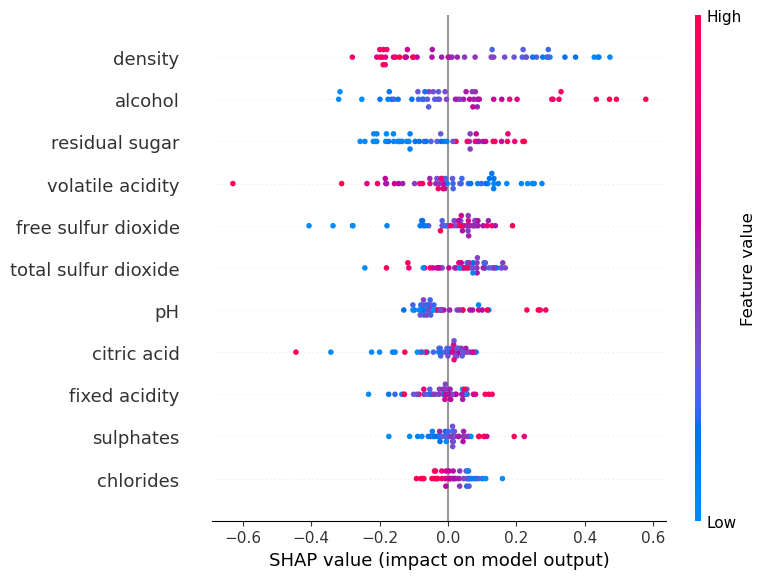

In [72]:
background_data = X_train.sample(200, random_state=1)  # Use a subset of the training data for background
test_data = X_test.sample(50, random_state=1)  # Use a subset of the test data for SHAP values

explainer = shap.KernelExplainer(svr.predict, background_data)

shap_values = explainer.shap_values(test_data)

shap.summary_plot(shap_values, test_data, feature_names=X.columns)

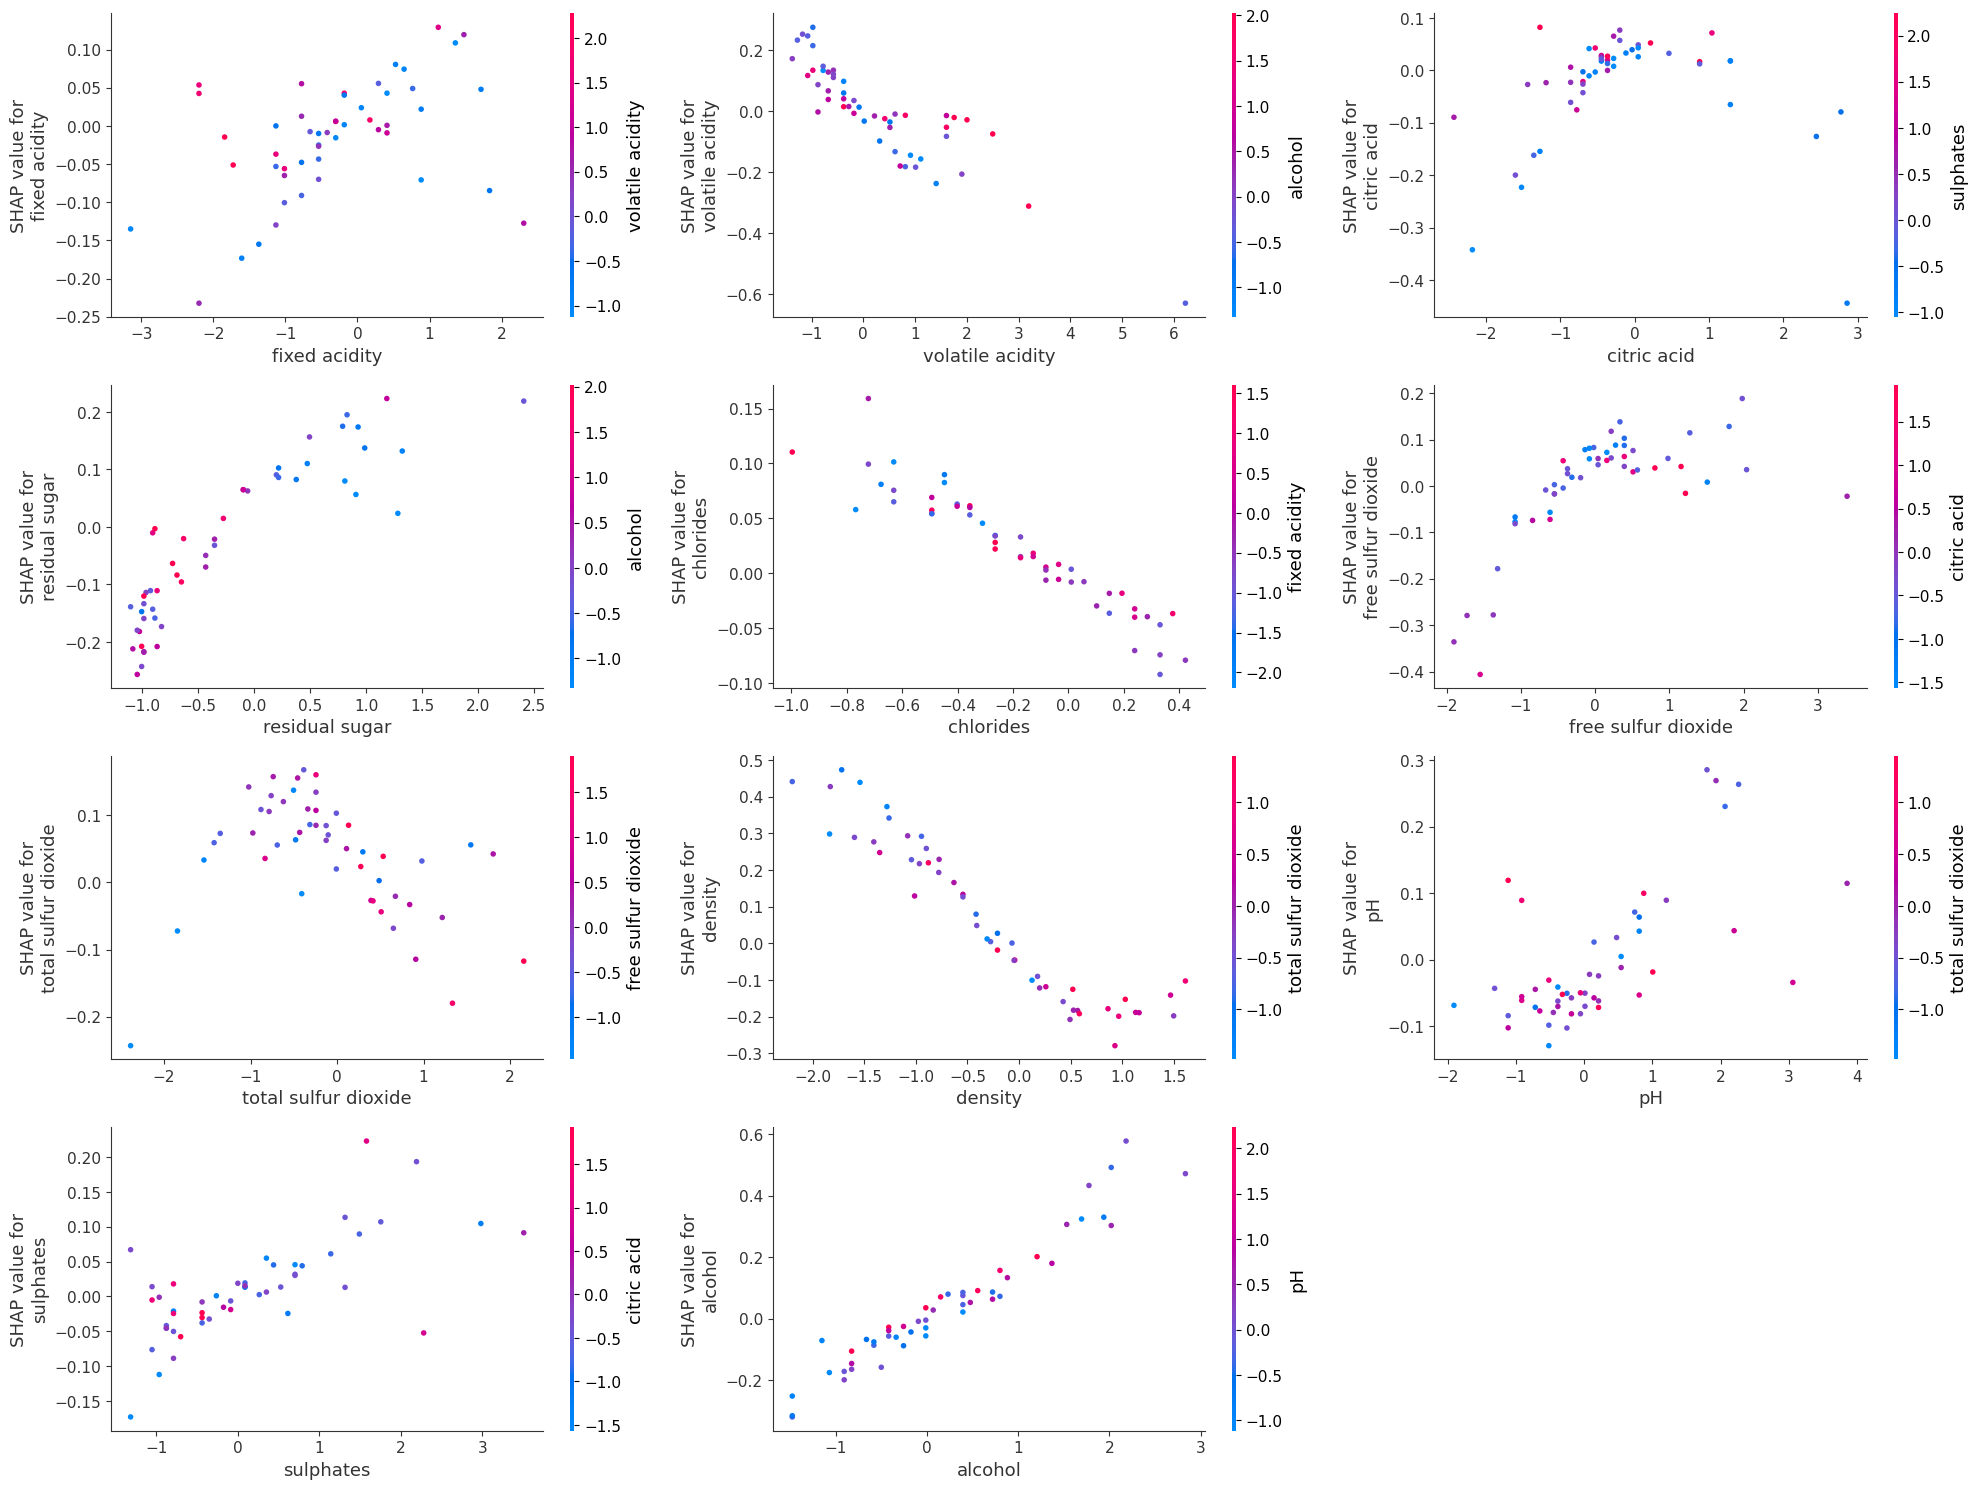

In [73]:
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
ax = ax.flatten()

for i in range(X.shape[1]):
    shap.dependence_plot(i, shap_values, test_data, feature_names=X.columns, ax=ax[i], show=False)

for j in range(X.shape[1], len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


In [74]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values, feature_names=X.columns)